# ANN-to-SNN Conversion for a Multilayer Perceptron (MLP)

Download the Jupyter notebook : [MNIST_MLP.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/docs/example/MNIST_MLP.ipynb)

This script will demonstrate the required steps to transform a multilayer perceptron trained on MNIST using TensorFlow into an SNN network usable in ANNarchy.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

## Load MNIST

First we need to load the MNIST test and training which is already provided by tensorflow.

In [2]:
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255.
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255.
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

11490434/11490434 [==============================] - 1s 0us/step


## TensorFlow MLP Architecture

The TensorFlow network was build with the functional API as follow:

```
inputs = tf.keras.layers.Input(shape=(784,))
h1= tf.keras.layers.Dense(64,use_bias=False, activation='relu')(inputs)
h2= tf.keras.layers.Dense(128,use_bias=False,activation='relu')(h1)
h3= tf.keras.layers.Dense(128,use_bias=False,activation='relu')(h2)
output=tf.keras.layers.Dense(10,use_bias=False,activation='softmax')(h3)

model= tf.keras.Model(inputs,output)

```

We used the standard gradient descent (SGD) optimizer and used the categorical crossentropy loss.

In [3]:
inputs = tf.keras.layers.Input(shape=(784,))
x= tf.keras.layers.Dense(128, 
                          use_bias=False, 
                          activation='relu')(inputs)
x= tf.keras.layers.Dense(128, 
                          use_bias=False,
                          activation='relu')(x)
x=tf.keras.layers.Dense(10, 
                          use_bias=False,
                          activation='softmax')(x)

model= tf.keras.Model(inputs, x)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# Loss function
model.compile(
    loss='categorical_crossentropy', # loss function
    optimizer=optimizer, # learning rule
    metrics=['accuracy'] # show accuracy
)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100352    
                                                                 
 dense_1 (Dense)             (None, 128)               16384     
                                                                 
 dense_2 (Dense)             (None, 10)                1280      
                                                                 
Total params: 118016 (461.00 KB)
Trainable params: 118016 (461.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Train the network

In [4]:
history = model.fit(
    X_train, T_train,       # training data
    batch_size=64,          # batch size
    epochs=20,              # Maximum number of epochs
    validation_split=0.1,   # Percentage of training data used for validation
)
model.save("mlp.h5")

2023-07-20 16:10:48.598899: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


Epoch 1/20
826/844 [============================>.] - ETA: 0s - loss: 2.1354 - accuracy: 0.3164

2023-07-20 16:10:52.254454: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18816000 exceeds 10% of free system memory.


844/844 [==============================] - 4s 3ms/step - loss: 2.1315 - accuracy: 0.3208 - val_loss: 1.9358 - val_accuracy: 0.5408
Epoch 2/20
844/844 [==============================] - 2s 3ms/step - loss: 1.7377 - accuracy: 0.6115 - val_loss: 1.4785 - val_accuracy: 0.6995
Epoch 3/20
844/844 [==============================] - 3s 3ms/step - loss: 1.3065 - accuracy: 0.7200 - val_loss: 1.0661 - val_accuracy: 0.7888
Epoch 4/20
844/844 [==============================] - 3s 3ms/step - loss: 0.9844 - accuracy: 0.7823 - val_loss: 0.8050 - val_accuracy: 0.8437
Epoch 5/20
844/844 [==============================] - 3s 3ms/step - loss: 0.7908 - accuracy: 0.8158 - val_loss: 0.6517 - val_accuracy: 0.8690
Epoch 6/20
844/844 [==============================] - 3s 3ms/step - loss: 0.6738 - accuracy: 0.8351 - val_loss: 0.5573 - val_accuracy: 0.8798
Epoch 7/20
844/844 [==============================] - 3s 4ms/step - loss: 0.5979 - accuracy: 0.8498 - val_loss: 0.4945 - val_accuracy: 0.8877
Epoch 8/20
844/84

/home/hdin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


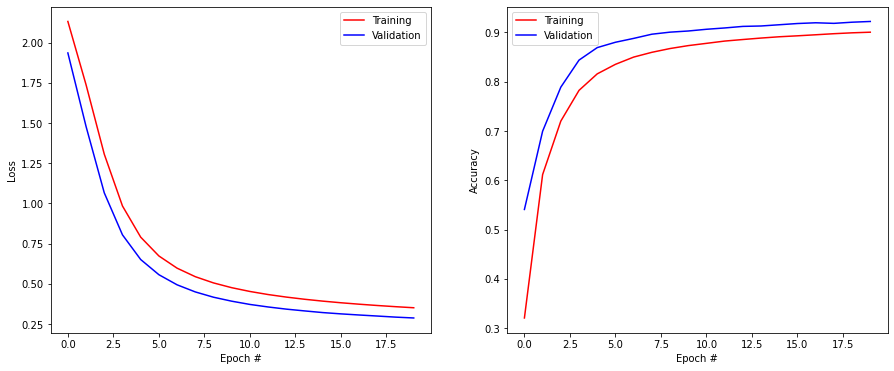

In [5]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [6]:
predictions_keras = model.predict(X_test)
test_loss, test_accuracy = model.evaluate(X_test, T_test)
print(f"Test accuracy: {test_accuracy}")

  1/313 [..............................] - ETA: 32s

2023-07-20 16:11:47.267385: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


 59/313 [====>.........................] - ETA: 0s - loss: 0.4051 - accuracy: 0.8861

2023-07-20 16:11:48.736018: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 2ms/step - loss: 0.3289 - accuracy: 0.9064
Test accuracy: 0.9064000248908997


## Initialize the Converter

As the first step, we create an instance of the ANN-to-SNN conversion tool. The function receives the *input_encoding* parameter, which is the type of input encoding we want to use. By default, there are *intrinsically bursting* ("IB"), *phase shift oscillation* ("PSO") and *Poisson* ("poisson") available.

In [7]:
from ANNarchy.extensions.ann_to_snn_conversion import ANNtoSNNConverter
snn_converter = ANNtoSNNConverter(input_encoding='IB')

ANNarchy 4.7 (4.7.3b) on linux (posix).


After that, we provide the TensorFlow model stored as h5py file to the conversion tool. The print-out of the network structure of the imported network is suppressed when *show_info*=False is provided to *init_from_keras_model*.

In [8]:
snn_converter.init_from_keras_model("mlp.h5")


Selected In/Out
----------------------
input encoding: IB
hidden neuron: IaF neuron
read-out method: spike_count

Show populations/layer
----------------------
dense geometry =  128
dense_1 geometry =  128
dense_2 geometry =  10

Show Connections/Projections
----------------------
--------
input_1  ->  dense
(784,) (128,)
weight_m : (128, 784)
--------
dense  ->  dense_1
(128,) (128,)
weight_m : (128, 128)
--------
dense_1  ->  dense_2
(128,) (10,)
weight_m : (10, 128)
Compiling network 1...  OK 


## Inference for 10k Samples

When the network has been built successfully, we can perform a test using all MNIST training samples. Using *duration_per_sample* the number of steps for one image can be adjusted.

In [9]:
predictions_snn = snn_converter.predict(X_test, duration_per_sample=100)

100%|████████████████████████████████████| 10000/10000 [00:35<00:00, 285.65it/s]


Dependent on the selected read-out method it may happen that multiple neurons are selected. In the following, we select one of the candidates randomly.


In [10]:
from numpy.random import choice
predictions_snn = [ [choice(p)] for p in predictions_snn ]


## SNN

Using the recorded predictions, we can now compute the accuracy using scikit-learn for all presented samples.

In [11]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(t_test, predictions_snn))
print(accuracy_score(t_test, predictions_snn))


              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.92      0.85      0.88      1032
           3       0.87      0.88      0.87      1010
           4       0.88      0.90      0.89       982
           5       0.87      0.80      0.83       892
           6       0.89      0.94      0.92       958
           7       0.92      0.90      0.91      1028
           8       0.83      0.85      0.84       974
           9       0.87      0.85      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

0.8929


## ANN

As ground-truth we can also analyze the predictions from the original ANN

In [12]:
print(classification_report(t_test, predictions_keras.argmax(axis=1)))
print(accuracy_score(t_test, predictions_keras.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.96      0.97      0.97      1135
           2       0.91      0.88      0.89      1032
           3       0.90      0.89      0.89      1010
           4       0.89      0.92      0.91       982
           5       0.88      0.83      0.85       892
           6       0.92      0.93      0.93       958
           7       0.92      0.91      0.91      1028
           8       0.85      0.86      0.86       974
           9       0.90      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000

0.9064


## ANN vs. SNN

A comparison between the predictions made by the ANN and SNN reveals potential different behavior.

In [13]:

print(classification_report(predictions_keras.argmax(axis=1), predictions_snn))
print(accuracy_score(predictions_keras.argmax(axis=1), predictions_snn))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1025
           1       0.98      0.99      0.98      1155
           2       0.97      0.93      0.95       993
           3       0.93      0.94      0.93      1004
           4       0.94      0.93      0.93      1022
           5       0.93      0.92      0.92       839
           6       0.94      0.99      0.96       968
           7       0.96      0.95      0.96      1016
           8       0.92      0.92      0.92       987
           9       0.92      0.92      0.92       991

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

0.9464


In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(predictions_keras.argmax(axis=1), predictions_snn)

array([[1001,    0,    3,    3,    0,    8,    7,    1,    1,    1],
       [   0, 1138,    1,    2,    0,    2,    0,    1,   10,    1],
       [   2,   11,  923,   21,    3,    0,   13,    5,   11,    4],
       [   2,    1,    7,  946,    1,   26,    1,    2,   16,    2],
       [   1,    1,    0,    0,  948,    3,   21,    2,    9,   37],
       [   7,    0,    0,   23,    5,  769,    8,    0,   24,    3],
       [   2,    2,    2,    0,    2,    2,  954,    0,    4,    0],
       [   4,    4,    5,    4,    5,    0,    0,  969,    1,   24],
       [   1,    4,   11,   19,    7,   17,   11,    2,  908,    7],
       [   1,    0,    3,    3,   37,    0,    0,   31,    8,  908]])